In [1]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import imageio
import numpy as np
import torch
import cv2
from tqdm import tqdm
from os import makedirs
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, ModelHiddenParams #, get_combined_args,
from time import time
import open3d as o3d
from copy import deepcopy
import torch
import math
from matplotlib import pyplot as plt

from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from scene import Scene as DynamicScene
from static_scene import Scene as StaticScene
from scene.feature_gaussian_model import GaussianModel as DynamicGaussianModel
from static_scene. gaussian_model import GaussianModel as StaticGaussianModel
# from gaussian_renderer import render
from utils.segment_utils import get_combined_args

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def rotate_point_cloud(point_cloud, displacement, rotation_angles, scales_bias):
    
    theta, phi, alpha = rotation_angles

    rotation_matrix_z = torch.tensor([
        [torch.cos(theta), -torch.sin(theta), 0],
        [torch.sin(theta),  torch.cos(theta), 0],
        [0,                0,               1]
    ]).to(point_cloud)
    
    rotation_matrix_x = torch.tensor([
        [1, 0,                0],
        [0, torch.cos(phi), -torch.sin(phi)],
        [0, torch.sin(phi),  torch.cos(phi)]
    ]).to(point_cloud)
    
    rotation_matrix_y = torch.tensor([
        [torch.cos(alpha), 0, torch.sin(alpha)],
        [0, 1, 0],
        [-torch.sin(alpha), 0, torch.cos(alpha)]
    ]).to(point_cloud)
    
    rotation_matrix = torch.matmul(rotation_matrix_z, rotation_matrix_x)
    rotation_matrix = torch.matmul(rotation_matrix, rotation_matrix_y)
    # print(rotation_matrix)
    
    point_cloud = point_cloud * scales_bias
    rotated_point_cloud = torch.matmul(point_cloud, rotation_matrix.T)
    # rotated_point_cloud = torch.matmul(point_cloud, rotation_matrix.t())
    displaced_point_cloud = rotated_point_cloud + displacement

    return displaced_point_cloud

@torch.no_grad()
def get_state_at_time(pc, timestamp=None, seg=False, static=False):
    if static:
        means3D = pc.get_xyz
        opacity = pc.get_opacity
        scales = pc.get_scaling
        rotations = pc.get_rotation
        shs = pc.get_features
        return means3D, scales, rotations, opacity, shs
    else: 
        if seg:
            # nearest interpolate
            diff = torch.abs(pc._time_map - timestamp)
            index = torch.argmin(diff)
            mask = pc._mask_table[index].bool()     
            
            means3D = pc.get_xyz[mask]
            time = torch.tensor(timestamp).to(means3D.device).repeat(means3D.shape[0],1)
            opacity = pc._opacity[mask]
            shs = pc.get_features[mask]
            scales = pc._scaling[mask]
            rotations = pc._rotation[mask]
        else:
            means3D = pc.get_xyz
            time = torch.tensor(timestamp).to(means3D.device).repeat(means3D.shape[0],1)
            opacity = pc._opacity
            shs = pc.get_features
            scales = pc._scaling
            rotations = pc._rotation

        means3D_final, scales_final, rotations_final, opacity_final, shs_final = pc._deformation(means3D, scales, 
                                                                    rotations, opacity, shs,
                                                                    time)
        scales_final = pc.scaling_activation(scales_final)
        rotations_final = pc.rotation_activation(rotations_final)
        opacity = pc.opacity_activation(opacity_final)
        return means3D_final, scales_final, rotations_final, opacity, shs

@torch.no_grad()
def render(viewpoint_camera, timestamp, gaussians: list, bg_color : torch.Tensor, scaling_modifier = 1.0, 
           motion_bias: list = [torch.tensor([0,0,0])], 
           rotation_bias: list = [torch.tensor([0,0])],
           scales_bias: list = [1]):
    # Create zero tensor. We will use it to make pytorch return gradients of the 2D (screen-space) means
    screenspace_points = None
    for pc in gaussians:
        if screenspace_points is None:
            screenspace_points = torch.zeros_like(pc.get_xyz, dtype=pc.get_xyz.dtype, requires_grad=True, device="cuda") + 0
        else:
            screenspace_points1 = torch.zeros_like(pc.get_xyz, dtype=pc.get_xyz.dtype, requires_grad=True, device="cuda") + 0
            screenspace_points = torch.cat([screenspace_points,screenspace_points1],dim=0)
    try:
        screenspace_points.retain_grad()
    except:
        pass
    
    # Set up rasterization configuration
    tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
    tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)
    raster_settings = GaussianRasterizationSettings(
        image_height=int(viewpoint_camera.image_height),
        image_width=int(viewpoint_camera.image_width),
        tanfovx=tanfovx,
        tanfovy=tanfovy,
        bg=bg_color,
        scale_modifier=scaling_modifier,
        viewmatrix=viewpoint_camera.world_view_transform.cuda(),
        projmatrix=viewpoint_camera.full_proj_transform.cuda(),
        sh_degree=gaussians[0].active_sh_degree,
        campos=viewpoint_camera.camera_center.cuda(),
        prefiltered=False,
        debug=False
    )

    rasterizer = GaussianRasterizer(raster_settings=raster_settings)
    means3D_final, scales_final, rotations_final, opacity_final, shs_final = None, None, None, None, None
    for index, pc in enumerate(gaussians):
        # means3D_final1, scales_final1, rotations_final1, opacity_final1, shs_final1 = get_state_at_time(pc, viewpoint_camera)
        # scales_final1 = pc.scaling_activation(scales_final1)
        # rotations_final1 = pc.rotation_activation(rotations_final1)
        # opacity_final1 = pc.opacity_activation(opacity_final1)
        if index == 0:
            continue
            means3D_final, scales_final, rotations_final, opacity_final, shs_final = get_state_at_time(pc, timestamp=timestamp, static=True)
        else:
            means3D_final1, scales_final1, rotations_final1, opacity_final1, shs_final1 = get_state_at_time(pc, timestamp=timestamp, seg=True)
            
            # print(means3D_final1.device)
            # print(motion_bias_t.device)
            # print()
            # transform
            motion_bias_t = motion_bias[index-1].to('cuda')
            rotation_bias_t = rotation_bias[index-1].to('cuda')
            means3D_final1 = rotate_point_cloud(means3D_final1, motion_bias_t, rotation_bias_t, scales_bias[index-1])
            scales_final1 = scales_final1 * scales_bias[index-1]
            
            # # merge 4dgs
            # means3D_final = torch.cat([means3D_final, means3D_final1], dim=0)
            # scales_final = torch.cat([scales_final, scales_final1], dim=0)
            # rotations_final = torch.cat([rotations_final, rotations_final1], dim=0)
            # opacity_final = torch.cat([opacity_final, opacity_final1], dim=0)
            # shs_final = torch.cat([shs_final, shs_final1], dim=0)
            
            means3D_final = means3D_final1
            scales_final = scales_final1
            rotations_final = rotations_final1
            opacity_final = opacity_final1
            shs_final = shs_final1
            

    colors_precomp = None
    cov3D_precomp = None
    rendered_image, _, radii, _ = rasterizer(
        means3D = means3D_final,
        means2D = screenspace_points,
        shs = shs_final,
        colors_precomp = colors_precomp,
        opacities = opacity_final,
        mask = torch.zeros((means3D_final.shape[0], 1), dtype=torch.float, device="cuda"),
        scales = scales_final,
        rotations = rotations_final,
        cov3D_precomp = cov3D_precomp)

    return {"render": rendered_image,
            "viewspace_points": screenspace_points,
            "visibility_filter" : radii > 0,
            "radii": radii}


def init_dynamic_gaussians(dataset : ModelParams, hyperparam, iteration : int, cam_view=None):
    with torch.no_grad():
        gaussians = DynamicGaussianModel(dataset.sh_degree, "scene", hyperparam)
        scene = DynamicScene(dataset, gaussians, load_iteration=iteration, mode='scene', shuffle=False, cam_view=cam_view)

        bg_color = [1,1,1] if dataset.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    print(f'Init {dataset.model_path} finished\n')
    return gaussians, scene, background

def init_static_gaussians(dataset : ModelParams, iteration : int):
    with torch.no_grad():
        gaussians = StaticGaussianModel(dataset.sh_degree)
        scene = StaticScene(dataset, gaussians, load_iteration=iteration, shuffle=False)

        bg_color = [1,1,1] if dataset.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    print(f'Init {dataset.model_path} finished\n')
    return gaussians, scene, background

def save_point_cloud(points, model_path, timestamp):
    output_path = os.path.join(model_path,"point_pertimestamp")
    if not os.path.exists(output_path):
        os.makedirs(output_path,exist_ok=True)
    points = points.detach().cpu().numpy()
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    ply_path = os.path.join(output_path,f"points_{timestamp}.ply")
    o3d.io.write_point_cloud(ply_path, pcd)


to8b = lambda x : (255*np.clip(x.cpu().numpy(),0,1)).astype(np.uint8)


In [3]:
model0 = "./output/hypernerf/misc/americano"
config0 = "arguments/hypernerf/default.py"

model1 = "./output/hypernerf/misc/americano"
config1 = "arguments/hypernerf/default.py"

render_path = "demo"

In [4]:
parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
hyperparam = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
# parser.add_argument("--skip_train", action="store_true")
# parser.add_argument("--skip_test", action="store_true")
# parser.add_argument("--quiet", action="store_true")
# parser.add_argument("--skip_video", action="store_true")
parser.add_argument("--modelpath0", type=str, default=model0)
parser.add_argument("--modelpath1", type=str, default=model1)
parser.add_argument("--configs1", type=str, default=config1)
# parser.add_argument("--configs3", type=str, default="arguments/dnerf_tv_2/mutant.py")
# parser.add_argument("--modelpath3", type=str, default="output/dnerf_tv_2/mutant")
# args = parser.parse_args(sys.argv[1:])

# model_background
# args0 = deepcopy(args)
args0 = get_combined_args(parser, model0, "scene")
import mmcv
from utils.params_utils import merge_hparams
config = mmcv.Config.fromfile(config0)
args0 = merge_hparams(args0, config)
args0.object_masks = False
args0.need_gt_masks = False

# model1
# args1 = deepcopy(args0)
args1 = get_combined_args(parser, model1, "scene")
import mmcv
from utils.params_utils import merge_hparams
config = mmcv.Config.fromfile(args1.configs1)
args1 = merge_hparams(args1, config)
# args1 = get_combined_args(args1, model1, "scene")
args1.object_masks = False
args1.need_gt_masks = False

Looking for config file in ./output/hypernerf/misc/americano/cfg_args
Config file found at: ./output/hypernerf/misc/americano/cfg_args
Looking for config file in ./output/hypernerf/misc/americano/cfg_args
Config file found at: ./output/hypernerf/misc/americano/cfg_args


In [6]:
gaussians0, scene0, background = init_dynamic_gaussians(model.extract(args0), hyperparam.extract(args0), args0.iteration)
gaussians1, scene1, background = init_dynamic_gaussians(model.extract(args1), hyperparam.extract(args1), args1.iteration)

gaussians = [gaussians0, gaussians1]
gaussians1.load_mask_table(os.path.join(args1.model_path, "segment_results", "americano.pt"))

mode:  scene
Loading trained model at iteration 14000
load finished


132it [00:00, 76949.01it/s]

format finished
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [38.7918396  10.79985237 83.10951233] [-17.94255638 -68.1852951    9.00503731]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 38.7918,  10.7999,  83.1095],
        [-17.9426, -68.1853,   9.0050]])


loading model from exists./output/hypernerf/misc/americano/point_cloud/iteration_14000
Init ./output/hypernerf/misc/americano finished

mode:  scene
Loading trained model at iteration 14000
load finished


132it [00:00, 78945.98it/s]

format finished
Loading Training Cameras
Loading Test Cameras
Loading Video Cameras
Deformation Net Set aabb [38.7918396  10.79985237 83.10951233] [-17.94255638 -68.1852951    9.00503731]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 38.7918,  10.7999,  83.1095],
        [-17.9426, -68.1853,   9.0050]])


loading model from exists./output/hypernerf/misc/americano/point_cloud/iteration_14000
Init ./output/hypernerf/misc/americano finished



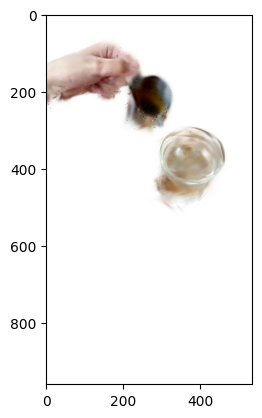

: 

In [40]:
motion_bias1 = torch.tensor([0, 0, 0])
# rotation_bias1 = torch.tensor([np.pi/4, np.pi/4])
rotation_bias1 = torch.tensor([0 ,0, 0])
scales_bias1 = 1

fix_viewpoint = scene0.getVideoCameras()[20]
timestamp = scene1.getVideoCameras()[20].time

result = render(fix_viewpoint, timestamp,
                gaussians, 
                bg_color=background,
                motion_bias=[motion_bias1],
                rotation_bias=[rotation_bias1],
                scales_bias = [scales_bias1])

plt.imshow(to8b(result["render"]).transpose(1,2,0))

## Render Video.

In [ ]:
render_images=[]

if not os.path.exists(render_path):
    os.makedirs(render_path, exist_ok=True)

fix_viewpoint = scene0.getTrainCameras()[81]

for index, viewpoint in tqdm(enumerate(scene1.getVideoCameras())):
    result = render(fix_viewpoint, viewpoint.time,
                    gaussians, 
                    bg_color=background,
                    motion_bias=[motion_bias1],
                    rotation_bias=[rotation_bias1],
                    scales_bias = [scales_bias1])
    render_images.append(to8b(result["render"]).transpose(1,2,0))
    
    # torchvision.utils.save_image(result["render"],os.path.join(render_path,f"output_image{index}.png"))
    
imageio.mimwrite(os.path.join(render_path, 'video_rgb.mp4'), render_images, fps=30) 
# points = get_state_at_time(gaussians, viewpoint)
# save_point_cloud(points, args.model_path, index)